In [81]:
%matplotlib inline 
try:
    session.close()
except:
    print('no active session')

In [82]:

## based on 
# https://danijar.com/building-variational-auto-encoders-in-tensorflow/
# https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
## Imports
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn.model_selection
import os, glob, shutil, math, time
# reset tf graph  
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.ERROR)
#sess = tf.Session()
session = tf.InteractiveSession()
## data pipeline from R-prepared CSV

df = pd.read_csv("split_x_hier.csv",sep=",")
data = df.values
odf = pd.read_csv("split_y.csv",sep=",")
outcomes = odf.values


## seed 
np.random.seed(134)

m = np.shape(data)[0]
d = np.shape(data)[1]
p = 1

## Functions
def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
#     print('unnormalizing with number of dimensions = ' +str(d))
    dat = (np.multiply(scaled_dat.T,np.sqrt(train_var),)+train_mean).T
    return(dat)

def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data.T - train_mean),np.sqrt(train_var),).T
    return(scaled_dat)
    
## data generation
# get random partition
perm = np.random.permutation(np.shape(data)[0])
data = data[perm,:]
outcomes = outcomes[perm,:]
msk = np.random.rand(np.shape(data)[0]) < 0.70
print('msk[8] = ' + str(msk[8]))

# test and train split
train_data_x = data[msk]
test_data_x = data[~msk]
train_data_y = outcomes[msk]
test_data_y = outcomes[~msk]



# non-dimenisionalization
train_var_x = np.var(train_data_x,0).reshape(d,1)
train_mean_x = np.mean(train_data_x,0).reshape(d,1)
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)

train_var_y = np.var(train_data_y,0).reshape(p,1)
train_mean_y = np.mean(train_data_y,0).reshape(p,1)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)

# scaled_train_data_x = np.array([[1,2,3,1],[2,3,4,1],[6,1,2,1]])
# scaled_train_data_y =tf.reshape(np.array([0.5,0.58,0.77]),shape=[3,1])
# scaled_test_data_x = np.array([[9,7,8,2],[8,2,2,1]])
# scaled_test_data_y = tf.reshape(np.array([0.55,0.8]),shape=[2,1])
# d = 3
n_input = d # data input (img shape: 28*28)
n =  np.shape(scaled_train_data_x)[0]
ntest =  np.shape(scaled_test_data_x)[0]

## tf variable placeholders for feeding
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32,[None,n_input],name="X")
    Y = tf.placeholder(tf.float32,[None,n_input],name="Y")
    global_step = tf.Variable(0, trainable=False)
    keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

print(scaled_train_data_x.shape)

msk[8] = False
normalizing with number of dimensions = 155
normalizing with number of dimensions = 155
normalizing with number of dimensions = 1
normalizing with number of dimensions = 1
(1006, 155)


In [83]:
def myPairwiseDist(X,Y):
    tile1 = tf.tile(tf.expand_dims(X, 0), [Y.shape[0], 1, 1])
    tile2 = tf.tile(tf.expand_dims(Y, 1), [1,X.shape[0] , 1])
    pairwiseEuclideanDistance = tf.reduce_sum(tf.square(tf.subtract(tile1, tile2)), 2)
    return pairwiseEuclideanDistance
def myRBFKernel(gamma,X,Y):
    K = tf.exp(tf.multiply(tf.cast(-1*gamma,dtype="float64"), tf.cast(myPairwiseDist(X,Y),dtype="float64")))
    return K
def kernelModel(alpha,K):
    ymod = tf.matmul(K,alpha)
    return ymod
def hybridKernelModel(alpha,racK,oc,oK,hfc,hfK):
    ymod = tf.add_n([tf.matmul(K,alpha),tf.matmul(oK,oc),tf.matmul(hfK,hfc)])
    return ymod
def ridgeReg(alpha):
    penalty = tf.norm(alpha)
    return penalty

def objective(alpha,ytrain,K,lam):
    o = tf.cast(tf.nn.l2_loss(tf.subtract(ytrain,kernelModel(alpha,K))),dtype="float64") + tf.cast(tf.abs(lam),dtype="float64")*tf.cast(ridgeReg(alpha),dtype="float64")
    return o
    
def predictiveModel(x,alpha,xtrain,gamma):
    predK = kernelModel(alpha,myRBFKernel(xtrain,x))
    return predK
def solveLinearKernel(K,lam,ytrain):
    mat = tf.add(tf.matmul(tf.transpose(K),K),lam*tf.eye(num_rows=tf.cast(scaled_train_data_y.shape[0],dtype="int32"),
                                                         dtype="float64"))
    rhs = tf.matmul(tf.transpose(K),ytrain)
    alpha = tf.matrix_solve(mat,rhs)
    return alpha
def kernelsim(K1,K2):
    return(tf.norm(tf.subtract(K1,K2)))
def hierachicalKernel(beta,Klist):
    K = tf.add_n([tf.multiply(beta[0],Klist[0]),tf.multiply(beta[1],Klist[1]),
               tf.multiply(beta[2],Klist[2]),tf.multiply(beta[3],Klist[3]),
               tf.multiply(beta[4],Klist[4])])
    return K
def RAChybridKernel(beta,Klist):
    K = tf.add_n([tf.multiply(beta[0],Klist[0]),tf.multiply(beta[1],Klist[1]),
               tf.multiply(beta[2],Klist[2])])
    return K
def makeKlist(gammaList,X,Y,vlens):
    Klist = list()
    count = 0
    for i,l in enumerate(vlens):
        thisK = myRBFKernel(gammaList[i],X[:,count:l+count],Y[:,count:l+count])
        Klist.append(thisK)
        count += l
    return Klist



In [84]:
## divide data
nlocal = 21
nmid = 27
ndist = 105
nglob = 1
nal  = 1

vlens = [nlocal,nmid,ndist,nglob,nal]

#def makeBetaFromControl(controlMix):
#    beta 
controlMix = tf.Variable(tf.log(tf.Variable([0.3,0.15,0.15,0.15,0.05],name="alphain", dtype="float64")), dtype="float64")
hybridControlMix = tf.Variable(tf.log(tf.Variable([0.5,0.3,0.2],name="halphain", dtype="float64")), dtype="float64")
#gammaControl = tf.Variable(tf.log(tf.Variable([1.16991382e-01,5.66240167e-02,
#                                               1.40419208e-02,1.82199411,1.44108231e+01],name="gammain", dtype="float64")), dtype="float64")
gammaControl = tf.Variable(tf.log(tf.Variable([1e-3,1e-3,1e-3,1,1e-2],name="gammain", dtype="float64")), dtype="float64")
betas = tf.divide(tf.exp(controlMix),tf.reduce_sum(tf.exp(controlMix)))
   

gammaList = tf.exp(gammaControl)


## initialize all
init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
session.run(init)
session.run(init_l)


print(gammaList)
print(gammaList.eval())

Klist = makeKlist(gammaList,scaled_train_data_x,scaled_train_data_x,vlens)
Klistt = makeKlist(gammaList,scaled_train_data_x,scaled_test_data_x,vlens)
HK = hierachicalKernel(betas,Klist)
HKt = hierachicalKernel(betas,Klistt)



Tensor("Exp_2:0", shape=(5,), dtype=float64)
[0.001 0.001 0.001 1.    0.01 ]


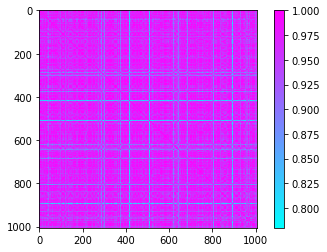

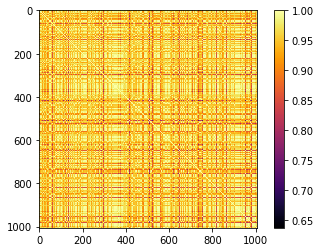

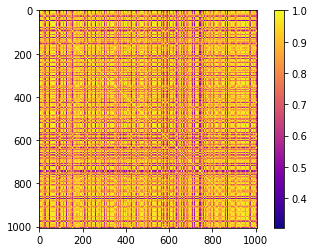

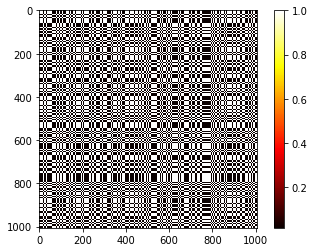

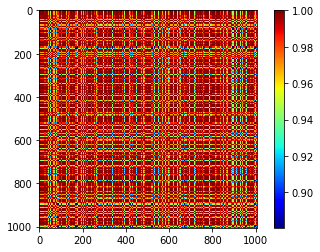

In [85]:


plt.imshow((Klist[0].eval()), cmap='cool', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((Klist[1].eval()), cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((Klist[2].eval()), cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((Klist[3].eval()), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((Klist[4].eval()), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()
# session.close()

In [51]:
#3 intial weights
alpha = tf.Variable(tf.random_normal([n,1],mean=0.0,stddev=1.0,dtype="float64"),name="alpha", dtype="float64")
alphaH = tf.Variable(tf.random_normal([n,1],mean=0.0,stddev=1.0,dtype="float64"),name="alpha", dtype="float64")

In [52]:
## set kernel
gamma = tf.Variable(8.483429e-3, tf.float64)
K  = myRBFKernel(gamma,scaled_train_data_x,scaled_train_data_x)
Kt  = myRBFKernel(gamma,scaled_train_data_x,scaled_test_data_x)

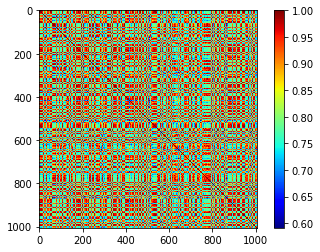

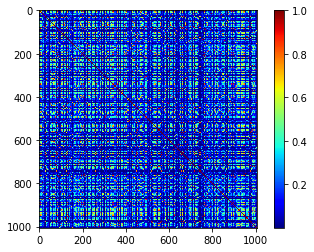

In [53]:


init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
session.run(init)
session.run(init_l)


plt.imshow((HK.eval()), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((K.eval()), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()


In [54]:
## linear solve
lam = tf.Variable(1.291550e-07, tf.float64)
bestAlpha = solveLinearKernel(K,1.668101e-10,scaled_train_data_y)
bestAlphaH = solveLinearKernel(HK,1.668101e-10,scaled_train_data_y)


In [55]:
## define performance metrics
train_pred = kernelModel(alpha,K)
test_pred = kernelModel(alpha,Kt)
train_errors = tf.subtract(train_pred,scaled_train_data_y)
test_errors = tf.subtract(test_pred,scaled_test_data_y)
train_mae = tf.metrics.mean_absolute_error(train_pred,scaled_train_data_y)
test_mae = tf.metrics.mean_absolute_error(test_pred,scaled_test_data_y)
train_rmse = tf.metrics.mean_squared_error(train_pred*np.sqrt(train_var_y),scaled_train_data_y*np.sqrt(train_var_y))
test_rmse = tf.metrics.mean_squared_error(test_pred*np.sqrt(train_var_y),scaled_test_data_y*np.sqrt(train_var_y))


## linear solve
train_pred_ds = kernelModel(bestAlpha,K)
test_pred_ds = kernelModel(bestAlpha,Kt)
train_errors_ds = tf.subtract(train_pred_ds,scaled_train_data_y)
test_errors_ds = tf.subtract(test_pred_ds,scaled_test_data_y)
train_mae_ds = tf.metrics.mean_absolute_error(train_pred_ds,scaled_train_data_y)
test_mae_ds = tf.metrics.mean_absolute_error(test_pred_ds,scaled_test_data_y)
train_rmse_ds = tf.metrics.mean_squared_error(train_pred_ds*np.sqrt(train_var_y),scaled_train_data_y*np.sqrt(train_var_y))
test_rmse_ds = tf.metrics.mean_squared_error(test_pred_ds*np.sqrt(train_var_y),scaled_test_data_y*np.sqrt(train_var_y))


## HK optimize
train_pred_HK = kernelModel(bestAlphaH,HK)
test_pred_HK = kernelModel(bestAlphaH,HKt)
train_errors_HK = tf.subtract(train_pred_HK,scaled_train_data_y)
test_errors_HK = tf.subtract(test_pred_HK,scaled_test_data_y)
train_mae_HK = tf.metrics.mean_absolute_error(train_pred_HK,scaled_train_data_y)
test_mae_HK = tf.metrics.mean_absolute_error(test_pred_HK,scaled_test_data_y)
train_rmse_HK = tf.metrics.mean_squared_error(train_pred_HK*np.sqrt(train_var_y),scaled_train_data_y*np.sqrt(train_var_y))
test_rmse_HK = tf.metrics.mean_squared_error(test_pred_HK*np.sqrt(train_var_y),scaled_test_data_y*np.sqrt(train_var_y))



In [56]:
## build optimizer
optimizer =tf.train.AdamOptimizer(learning_rate=1e-3)
loss = objective(alpha,scaled_train_data_y,K,lam)
rt = optimizer.minimize(loss,var_list=[alpha])

optimizerH =tf.train.AdamOptimizer(learning_rate=1e-2)
lossH = objective(bestAlphaH,scaled_train_data_y,HK,lam)
rtH = optimizerH.minimize(lossH,var_list=[controlMix])


optimizerHgam =tf.train.AdamOptimizer(learning_rate=1e-2)
lossH = objective(bestAlphaH,scaled_train_data_y,HK,lam)
rtHg = optimizerH.minimize(lossH,var_list=[controlMix,gammaControl])



In [57]:
## make kernels similar 
optimizerKS =tf.train.AdamOptimizer(learning_rate=1e-2)
optimizerKScrude =tf.train.GradientDescentOptimizer(learning_rate=1e-3)
lossKS = kernelsim(K,HK)
rtKS = optimizerKS.minimize(lossKS,var_list=[controlMix,gammaControl])
rtKSc = optimizerKScrude.minimize(lossKS,var_list=[controlMix,gammaControl])




In [58]:
## initialize all
init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
session.run(init)
session.run(init_l)
alpha_err = tf.reduce_sum(tf.abs(tf.subtract(alpha,bestAlpha)))

In [63]:
ns = 100
for step in range(ns+1):  
  session.run(rtKSc)
  if not step % int(np.floor(ns/10)):
        print("step", step, "loss:",  session.run(lossKS),'betas',sum(betas.eval()),str(betas.eval()))


('step', 0, 'loss:', 753.0663926262241, 'betas', 0.9999999999999999, '[0.5788285  0.08670457 0.32380082 0.00792891 0.00273719]')
('step', 10, 'loss:', 632.483213389244, 'betas', 1.0000000000000002, '[0.38160188 0.08188643 0.52549946 0.00825167 0.00276057]')
('step', 20, 'loss:', 246.60971069248404, 'betas', 1.0000000000000002, '[0.13098204 0.04565914 0.81596141 0.00556745 0.00182996]')
('step', 30, 'loss:', 145.7327815235089, 'betas', 1.0, '[0.07098994 0.02965236 0.894      0.00403576 0.00132194]')
('step', 40, 'loss:', 143.29758440472375, 'betas', 1.0000000000000002, '[0.06223538 0.02689097 0.90588745 0.00375819 0.00122802]')
('step', 50, 'loss:', 143.08337477237288, 'betas', 1.0, '[0.0591603  0.0258894  0.91009494 0.00366177 0.00119359]')
('step', 60, 'loss:', 142.98955779054575, 'betas', 1.0, '[0.05742683 0.02531619 0.91247277 0.00361031 0.00117391]')
('step', 70, 'loss:', 142.92595952034998, 'betas', 0.9999999999999999, '[0.05624514 0.02492043 0.91409634 0.00357769 0.00116041]')
('

In [70]:
ns = 1000
for step in range(ns+1):  
  session.run(rtKS)
  if not step % int(np.floor(ns/10)):
        print("step", step, "loss:",  session.run(lossKS),'betas',sum(betas.eval()),str(betas.eval()))


('step', 0, 'loss:', 158.25610317784995, 'betas', 0.9999999999999999, '[4.18335485e-02 6.75412513e-01 2.76941367e-01 6.87656930e-05\n 5.74380661e-03]')
('step', 100, 'loss:', 79.06041720159622, 'betas', 0.9999999999999999, '[2.64452815e-01 1.79138494e-01 5.28998484e-01 5.53611704e-05\n 2.73548467e-02]')
('step', 200, 'loss:', 78.50520296577905, 'betas', 0.9999999999999998, '[2.82360059e-01 1.63857285e-01 5.27168815e-01 5.25534375e-05\n 2.65612873e-02]')
('step', 300, 'loss:', 78.41995539880065, 'betas', 0.9999999999999999, '[2.89831764e-01 1.57866581e-01 5.26655797e-01 5.07539471e-05\n 2.55951043e-02]')
('step', 400, 'loss:', 78.41616518429198, 'betas', 1.0000000000000002, '[2.91472187e-01 1.56633432e-01 5.26500782e-01 4.95034462e-05\n 2.53440947e-02]')
('step', 500, 'loss:', 78.41604899280206, 'betas', 1.0000000000000002, '[2.91723417e-01 1.56447712e-01 5.26475878e-01 4.83679381e-05\n 2.53046257e-02]')
('step', 600, 'loss:', 78.41601543060098, 'betas', 1.0, '[2.91755407e-01 1.56424623

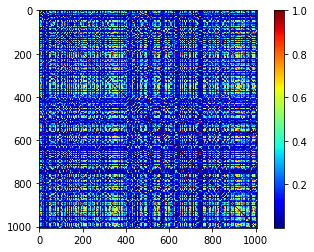

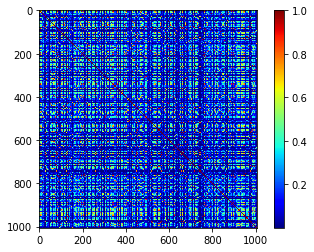

[1.16906530e-01 5.63036206e-02 1.40155421e-02 2.86561728e+00
 3.76552672e+01]


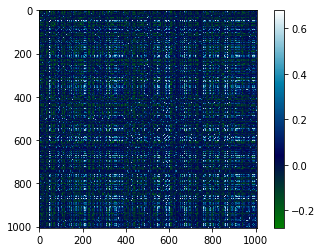

In [80]:
plt.imshow((HK.eval()), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((K.eval()), cmap='jet', interpolation='nearest')
plt.colorbar()
plt.show()
print(gammaList.eval())

plt.imshow((tf.subtract(HK,K).eval()), cmap='ocean', interpolation='nearest')
plt.colorbar()
plt.show()


In [ ]:
session.run(bestAlpha)
print("starting at", "loss:", session.run(loss),'err',session.run(alpha_err),'gamma',session.run(gamma))
print("starting at at", "loss:", session.run(lossH),'betas',betas.eval(),'gamma',(gammaList).eval())
set_alpha_to_linear_guess = alpha.assign(bestAlpha)
set_alpha_to_linear_guessH = alphaH.assign(bestAlphaH)
session.run(set_alpha_to_linear_guess)
session.run(set_alpha_to_linear_guessH)
print("after guess at", "loss:", session.run(loss),'err',session.run(alpha_err),'gamma',session.run(gamma))
print("after guess at", "loss:", session.run(lossH),'betas',betas.eval(),'gamma',(gammaList).eval())

In [ ]:
# session.close()

In [ ]:

print("starting at", "loss:", session.run(loss),'err',session.run(alpha_err),'gamma',session.run(gamma))


In [79]:
ns = 5000
for step in range(ns+1):  
  session.run(rtH)
  if not step % int(np.floor(ns/10)):
#         print("step", step, "loss:", session.run(loss),'err',session.run(alpha_err))
        print("step", step, "loss:",  session.run(lossH),'betas',sum(betas.eval()),str(betas.eval()))
print('train op done, metrics, units' )
resc =  lambda x: str(x*np.sqrt(train_var_y)).strip('[]')
print('MAEs',resc(session.run(train_mae_HK)[1]),"|",resc(session.run(test_mae_HK)[1]))
print('RMSE',np.sqrt(session.run(train_rmse_HK)[1]),"|",np.sqrt(session.run(test_rmse_HK)[1]))


('step', 0, 'loss:', 55.08906336350723, 'betas', 1.0, '[2.49519625e-02 6.58781849e-01 3.13320742e-01 1.18621432e-05\n 2.93358453e-03]')
('step', 500, 'loss:', 55.08876347848404, 'betas', 0.9999999999999999, '[2.47934773e-02 6.58701043e-01 3.14275464e-01 1.15210918e-05\n 2.21849420e-03]')
('step', 1000, 'loss:', 55.08886041622147, 'betas', 1.0, '[2.49481443e-02 6.58989278e-01 3.14355753e-01 1.13150034e-05\n 1.69550986e-03]')
('step', 1500, 'loss:', 55.08887258373479, 'betas', 1.0, '[2.50742842e-02 6.59146456e-01 3.14466891e-01 1.11628556e-05\n 1.30120590e-03]')
('step', 2000, 'loss:', 55.08856647131531, 'betas', 1.0, '[2.51680428e-02 6.59281803e-01 3.14535136e-01 1.10776436e-05\n 1.00394010e-03]')
('step', 2500, 'loss:', 55.08859563772914, 'betas', 1.0000000000000002, '[2.52385844e-02 6.59277300e-01 3.14693332e-01 1.10778180e-05\n 7.79706796e-04]')
('step', 3000, 'loss:', 55.08810365707774, 'betas', 1.0, '[2.52886229e-02 6.59389205e-01 3.14700526e-01 1.11840634e-05\n 6.10461536e-04]')
(

In [78]:

print('train op done, metrics, units, linear solve' )
resc =  lambda x: str(x*np.sqrt(train_var_y)).strip('[]')
print('MAEs',resc(session.run(train_mae_ds)[1]),"|",resc(session.run(test_mae_ds)[1]))
print('RMSE',np.sqrt(session.run(train_rmse_ds)[1]),"|",np.sqrt(session.run(test_rmse_ds)[1]))

train op done, metrics, units, linear solve
('MAEs', '0.36114371', '|', '3.08896107')
('RMSE', 0.931266, '|', 5.7456822)


In [45]:
print('train op done, metrics' )
print('MAEs',[session.run(train_mae)[1],session.run(test_mae)[1]])
print('RMSE',[session.run(train_rmse)[1],session.run(test_rmse)[1]])

print('train op done, metrics, units' )
resc =  lambda x: str(x*np.sqrt(train_var_y)).strip('[]')
print('MAEs',resc(session.run(train_mae)[1]),"|",resc(session.run(test_mae)[1]))
print('RMSE',np.sqrt(session.run(train_rmse)[1]),"|",np.sqrt(session.run(test_rmse)[1]))


train op done, metrics
('MAEs', [0.0005898781, 0.7828905])
('RMSE', [0.04335894, 676.0122])
train op done, metrics, units
('MAEs', '0.01520204', '|', '20.1762587')
('RMSE', 0.2082281, '|', 26.000235)


In [ ]:
session.close()

In [ ]:
np.sqrt((6.25909194**2))

In [ ]:
np.sqrt(train_var_y)

In [ ]:
np.sqrt(np.mean(np.power(test_errors.eval()*np.sqrt(train_var_y),2)))

In [ ]:
dm = myPairwiseDist(scaled_train_data_x,scaled_train_data_x).eval()

plt.imshow(dm, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()
